In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from datetime import datetime
import scipy.io as sio
import datetime
from datetime import datetime, timedelta
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import pickle
import matplotlib.dates as mdates


import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, moca, gaussian_vel_reconstruction, espra


#### Drifter Data

In [2]:
drifter_path = '/srv/scratch/z5297792/IN2023/CCE_2023_6h.nc'
drifter_dataset = nc.Dataset(drifter_path, mode='r')

u_drif, v_drif = drifter_dataset['ve'][:].data/100, drifter_dataset['vn'][:].data/100
lon_drif, lat_drif = drifter_dataset['longitude'][:].data, drifter_dataset['latitude'][:].data
ID_drif =  drifter_dataset['ID'][:]
secs = drifter_dataset['time'][:].data
tim_drif = [datetime.utcfromtimestamp(t).strftime('%Y-%m-%d %H:%M:%S') for t in secs]
df_drifters = pd.DataFrame({'ID': ID_drif.astype(int), 'Lon': lon_drif, 'Lat': lat_drif, 'u': u_drif, 'v': v_drif, 'Time': tim_drif})
df_drifters['Time'] = pd.to_datetime(df_drifters['Time'])
df_drifters = df_drifters[np.hypot(df_drifters.u, df_drifters.v) < 100]
df_drifters = df_drifters.reset_index().drop(columns=['index'])
df_drifters = df_drifters[df_drifters.Time < pd.Timestamp('2024-02-10 00:00:00')]
df_drifters.head()


,ID,Lon,Lat,u,v,Time
0,300534062034380,153.975,-37.651,0.003961,0.004561,2023-10-19 12:00:00
1,300534062034380,154.095,-37.579,0.004713,0.003265,2023-10-19 18:00:00
2,300534062034380,154.206,-37.523,0.004703,0.001505,2023-10-20 00:00:00
3,300534062034380,154.325,-37.520,0.004957,-0.000603,2023-10-20 06:00:00
4,300534062034380,154.448,-37.547,0.004584,-0.001956,2023-10-20 12:00:00


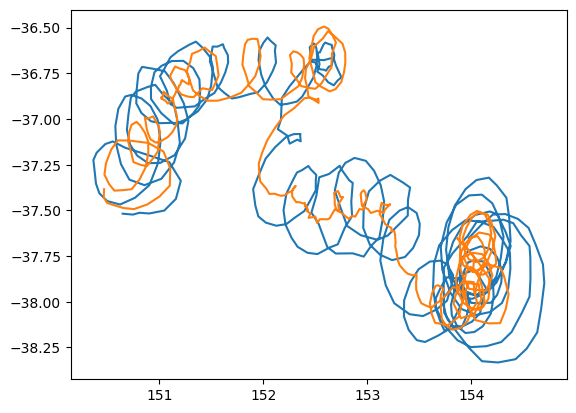

In [3]:
for d in df_drifters.ID.unique():
    df = df_drifters[df_drifters.ID==d].copy()
    plt.plot(df.Lon, df.Lat)
    

In [4]:
start = df_drifters.Time.min() + pd.Timedelta(days=1)
end   = df_drifters.Time.max() - pd.Timedelta(days=1)
times = pd.date_range(start, end, freq='D')

results = []
for t in times:
    mask = df_drifters.Time.between(t - pd.Timedelta(days=1),
                                     t + pd.Timedelta(days=1))
    xi, yi = df_drifters.loc[mask, ['Lon', 'Lat']].values.T
    ui, vi = df_drifters.loc[mask, ['u',   'v'  ]].values.T
    xc, yc, w, Q, Rc, psi0 = espra(xi, yi, ui, vi, Rc_max=50)
    results.append(dict(xc=xc, yc=yc, w=w, Q=Q, Rc=Rc, psi0=psi0, Time=t))

df_results = pd.DataFrame(results)
df_results

,xc,yc,w,Q,Rc,psi0,Time
0,154.267637,-37.953826,-0.026029,"[[-0.0072666875310506245, 0.000659990926537592...",5.477144,29.999790,2023-10-20 12:00:00
1,154.321904,-37.919899,-0.029592,"[[-0.00860559554466163, 0.0003390979540485265]...",5.477136,29.999674,2023-10-21 12:00:00
2,154.235778,-37.942048,-0.030406,"[[-0.007117291877619892, -0.000389311740622380...",5.476813,29.996246,2023-10-22 12:00:00
3,154.169484,-37.965548,-0.032797,"[[-0.007361517145338164, -0.000984175162243697...",5.476292,29.990488,2023-10-23 12:00:00
4,154.153028,-37.911515,-0.031857,"[[-0.007573243318833828, 0.0003533540088296107...",5.476085,29.988164,2023-10-24 12:00:00
...,...,...,...,...,...,...,...
107,150.676653,-37.187982,-0.035476,"[[-0.008871921026608843, 0.002152433001450708]...",5.477372,30.002027,2024-02-04 12:00:00
108,150.654736,-37.237212,-0.038747,"[[-0.007806389975327838, 0.0025276662953989913...",5.477209,30.000180,2024-02-05 12:00:00
109,150.705005,-37.318210,-0.035389,"[[-0.005028825757365147, -0.001447955260680779...",5.477003,29.997954,2024-02-06 12:00:00
110,150.685157,-37.294499,-0.043674,"[[-0.004910356873446585, -0.002288794605155998...",5.477101,29.999083,2024-02-07 12:00:00


(np.float64(150.15035),
 np.float64(154.91664999999998),
 np.float64(-38.4239),
 np.float64(-36.4021))

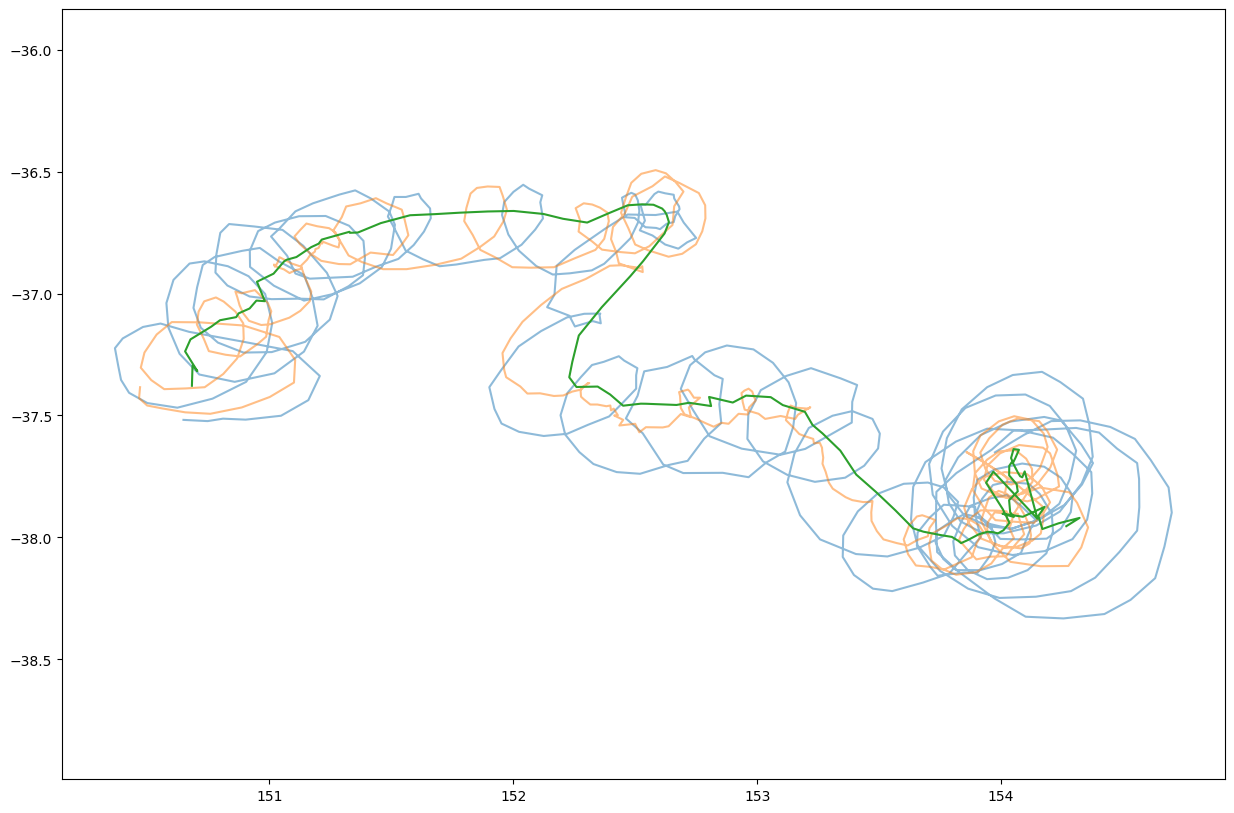

In [5]:
plt.figure(figsize=(15,10))
for d in df_drifters.ID.unique():
    df = df_drifters[df_drifters.ID==d].copy()
    plt.plot(df.Lon, df.Lat, alpha=.5)
    
plt.plot(df_results.xc, df_results.yc)
plt.axis('equal')

(np.float64(150.41775457062477),
 np.float64(154.55164189117812),
 np.float64(-38.14261266920982),
 np.float64(-36.511839662577266))

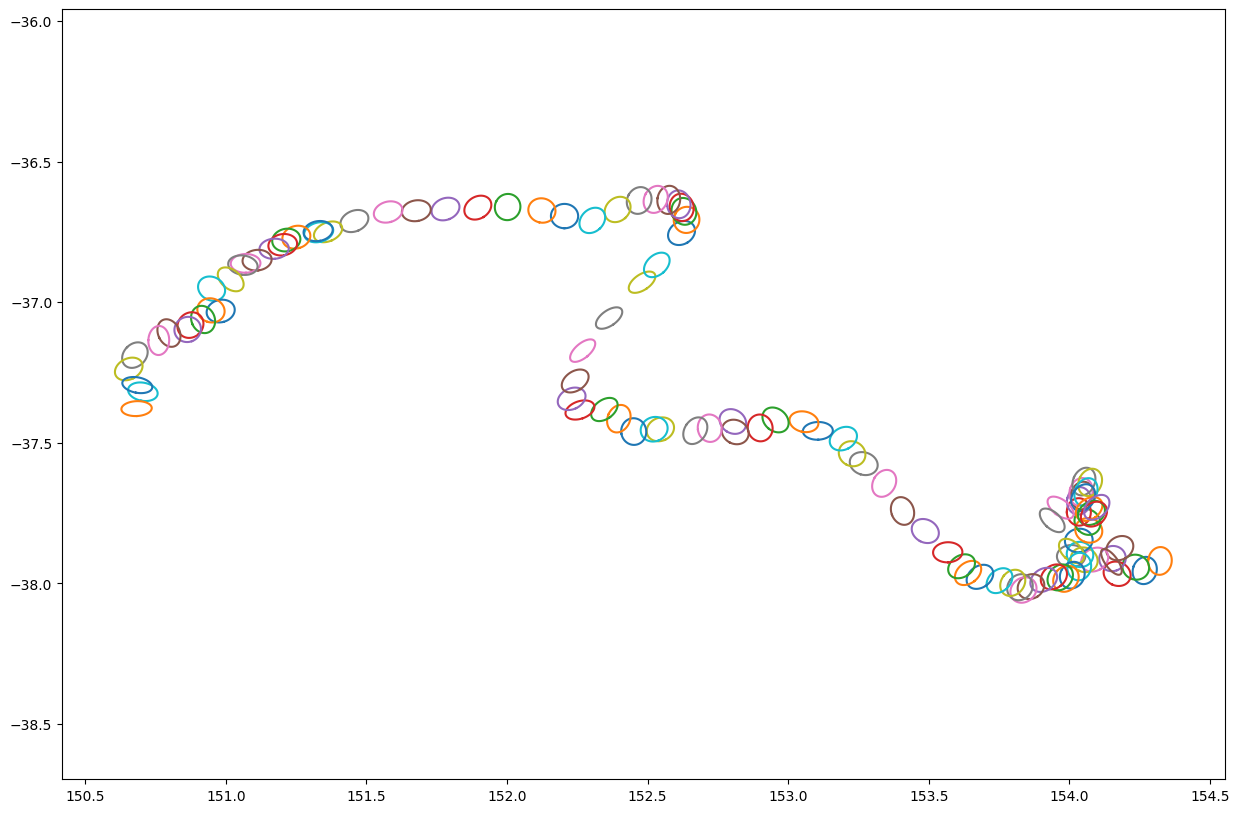

In [6]:
plt.figure(figsize=(15,10))
for (xc, yc, Q, Rc) in zip(df_results.xc, df_results.yc, df_results.Q, df_results.Rc):
    x_ell, y_ell = plot_ellipse(Q, (xc,yc), scale=Rc/100)
    plt.plot(x_ell, y_ell)
plt.axis('equal')


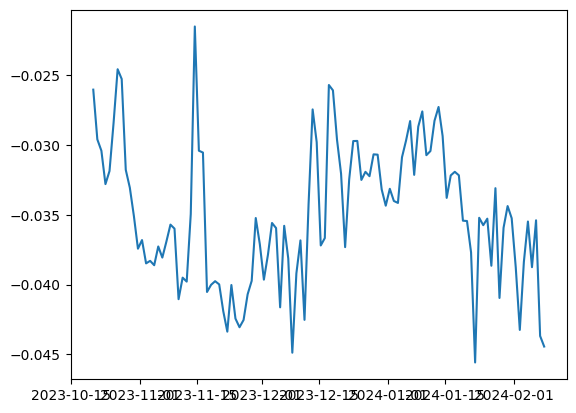

In [7]:
plt.plot(df_results.Time, df_results.w)

In [8]:
np.mean(df_results.Rc/df_results.psi0)

np.float64(0.1825760163043703)

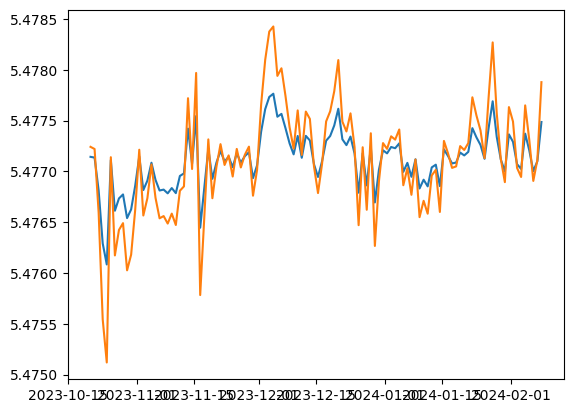

In [9]:
plt.plot(df_results.Time, df_results.Rc)
plt.plot(df_results.Time, df_results.psi0*0.1825760163043703)